# 6. PyTorch Transfer Learning

what is transfer learning??

this allows us to take patterns another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

## 0. Getting Setup

getting the modules


In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

from torchinfo import summary


from going_modular.going_modular import data_setup, engine




c:\Users\Anubhav\miniconda3\envs\nn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## 1. Get Data

In [3]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data\pizza_steak_sushi directory exists.


In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test" 

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for torchvision.models (manual creation)

when using a pretrained model, it's important that your custom data has the same transformation as the way it was used to train our model

In [5]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                               test_dir= test_dir,
                                                                               transform= manual_transforms,
                                                                               batch_size= 32,
                                                                               num_workers= 0)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x298bbb82920>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for torchvision.models() (auto creation)

we are using a pretrained model, it's imp that our data going in model is in same way as the original training data that went into the model.

when you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`

where, 
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use
* `DEFAULT` means the best available weights in the current torch version. 
    * **Note:** Depending on the model architecture you choose, you may also see other options such as `IMAGENET_V1` and `IMAGENET_V2` where generally the higher version number the better. Though if you want the best available, `DEFAULT` is the easiest option. See the `Docs` for better understanding.


In [7]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
auto_tranforms = weights.transforms()
auto_tranforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The benefit of this automatic creation is that we ensure we're using the same data transformation as the pretrained model used when it was trained.

the tradeoff os using auto is lack of customization.

we can use this to create dataloaders

In [9]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir= train_dir,
                                                                               test_dir= test_dir,
                                                                               transform= auto_tranforms,
                                                                               batch_size= 32,
                                                                               num_workers= 0)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x298bbb83490>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Alright, here comes the fun part!

Over the past few notebooks we've been building PyTorch neural networks from scratch.

And while that's a good skill to have, our models haven't been performing as well as we'd like.

That's where transfer learning comes in.

The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customise it to your use case.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in torchvision.models.

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

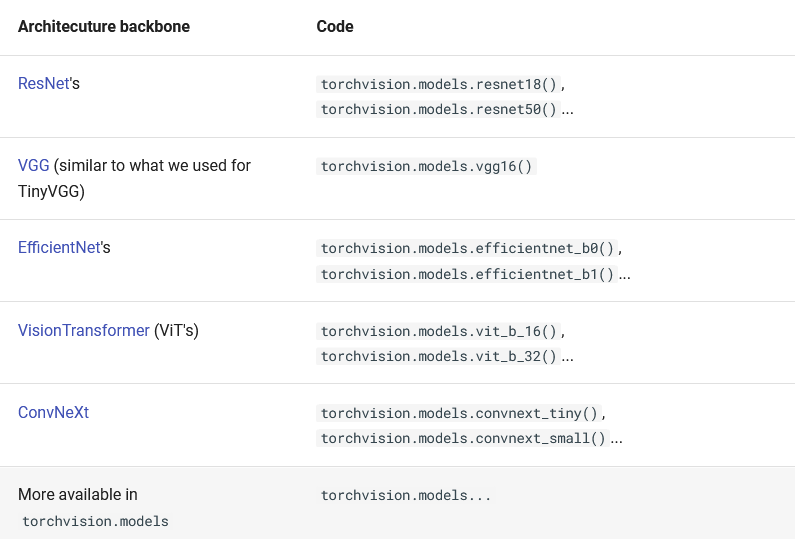

### 3.1 Which pretrained model should you use?

it depends on your problem/the device you're working with

higher number in model --> better performance but a larger model.

here where the issue comes

a mobile device cannot handle large model due to limited compute resources, thus we'd be looking for a smaller model to use.

we need to understand **performance vs. speed vs. size** tradeoff, which will come with time and practice.

### 3.2 Setting up a pretrained model


We would be using `torchvision.models.efficientnet_b0()`.


In [10]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights = weights).to(device)



In [11]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

If we print the model, we get something similar to the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png" alt="output of printing the efficientnet_b0 model from torchvision.models" width=900/>

Lots and lots and lots of layers.

This is one of the benefits of transfer learning, taking an existing model, that's been crafted by some of the best engineers in the world and applying to your own problem.

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default). 

### 3.3 Getting a summary of our model with `torchinfo.summary()`

use the summary method and feel it values like model, input_size, col_names, col_width, row_settings

* **Note:** Many modern models can handle input images of varying sizes thanks to `torch.nn.AdaptiveAvgPool2d()`, this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` to your models.



In [12]:
summary(model= model,
        input_size= (32,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: Freeze some base layers of a pretrained model and then adjust the ouput layer to suit our needs

In [13]:
for param in model.features.parameters():
    param.requires_grad = False

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p = 0.2, inplace= True),
    torch.nn.Linear(in_features=1280,
                    out_features= output_shape, 
                    bias= True)
).to(device)

In [15]:
summary(model= model,
        input_size= (32,3,224,224),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Few changes here:

* **Trainable column** - se see many have value as false this is effect of setting their attribute of requires_grad = False. this wont let these weights change during training.

* **Output shape of `classifier`**- the classifier now has output shape value of `[32,3]`. its trainable value is true meaning it will be able to update parameters during training.

* **Less trainable parameters**- Prev he had 5mil, now we have 3.5k.

## 4. Train model

loss fn and optimizer

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

# setup training and save the result

results = engine.train(model= model,
                       train_dataloader= train_dataloader,
                       test_dataloader= test_dataloader,
                       optimizer= optimizer, 
                       loss_fn= loss_fn,
                       epochs= 10,
                       device= device)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")



 10%|█         | 1/10 [00:02<00:22,  2.46s/it]

Epoch: 1 | train_loss: 1.0962 | train_acc: 0.3906 | test_loss: 0.9144 | test_acc: 0.5909


 20%|██        | 2/10 [00:04<00:17,  2.24s/it]

Epoch: 2 | train_loss: 0.8708 | train_acc: 0.7695 | test_loss: 0.7918 | test_acc: 0.8456


 30%|███       | 3/10 [00:06<00:15,  2.19s/it]

Epoch: 3 | train_loss: 0.7686 | train_acc: 0.7930 | test_loss: 0.7461 | test_acc: 0.8352


 40%|████      | 4/10 [00:08<00:13,  2.21s/it]

Epoch: 4 | train_loss: 0.7167 | train_acc: 0.7422 | test_loss: 0.6370 | test_acc: 0.8759


 50%|█████     | 5/10 [00:11<00:11,  2.24s/it]

Epoch: 5 | train_loss: 0.6291 | train_acc: 0.7695 | test_loss: 0.6272 | test_acc: 0.8968


 60%|██████    | 6/10 [00:13<00:09,  2.27s/it]

Epoch: 6 | train_loss: 0.5770 | train_acc: 0.7812 | test_loss: 0.5748 | test_acc: 0.8759


 70%|███████   | 7/10 [00:15<00:06,  2.26s/it]

Epoch: 7 | train_loss: 0.5276 | train_acc: 0.9141 | test_loss: 0.5465 | test_acc: 0.8759


 80%|████████  | 8/10 [00:18<00:04,  2.27s/it]

Epoch: 8 | train_loss: 0.5215 | train_acc: 0.8086 | test_loss: 0.5299 | test_acc: 0.8665


 90%|█████████ | 9/10 [00:20<00:02,  2.27s/it]

Epoch: 9 | train_loss: 0.5694 | train_acc: 0.7969 | test_loss: 0.5053 | test_acc: 0.8456


100%|██████████| 10/10 [00:22<00:00,  2.26s/it]

Epoch: 10 | train_loss: 0.4859 | train_acc: 0.8281 | test_loss: 0.4384 | test_acc: 0.9167
[INFO] Total training time: 22.597 seconds


## 5. Evaluate by plotting loss curves

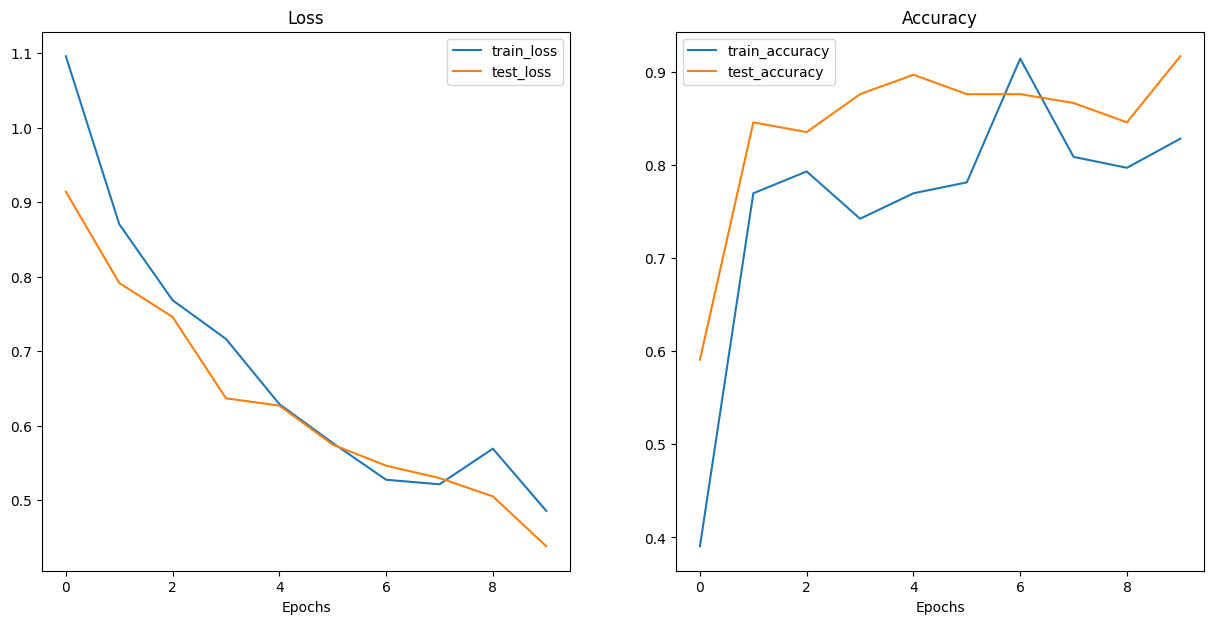

In [19]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

In [20]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

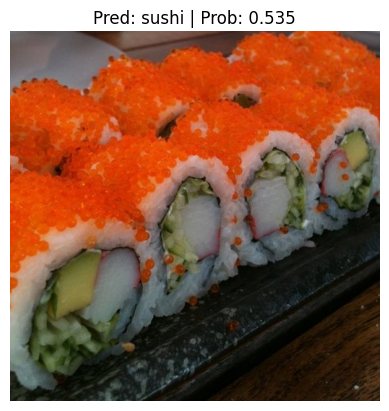

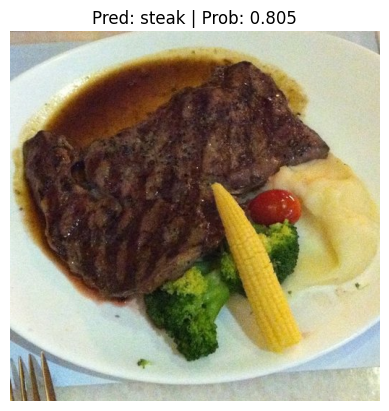

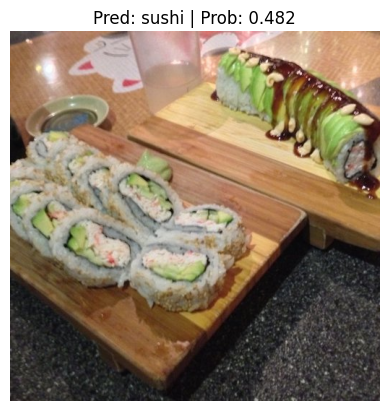

In [21]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 making prediction on custom image

data\04-pizza-dad.jpeg already exists, skipping download.


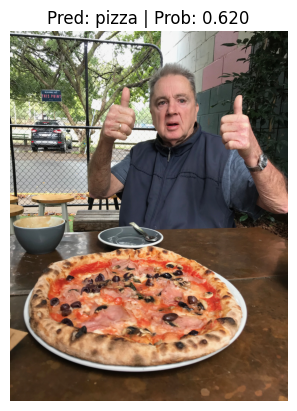

In [22]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)